In [1]:
%autosave 0

Autosave disabled


In [35]:
import io
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
# import seaborn as sns
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, LSTM, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib as mpl
from sklearn.metrics import mean_absolute_percentage_error
import datetime
import statistics
# import statsmodels.api as sm

# Dataset

In [3]:
# gcolab
# data_file = files.upload()

In [4]:
dt = pd.read_csv('AirQuality.csv', delimiter = ';', decimal = ',')
dt['Date_'] = pd.to_datetime(dt['Date'])
dt['Date_time'] = dt['Date_'].dt.strftime('%d/%m/%Y')
dt['Date_'] = pd.to_datetime(dt['Date_time'])
dt.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Date_,Date_time
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-03-10,03/10/2004
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-03-10,03/10/2004
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-03-10,03/10/2004
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-03-10,03/10/2004
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-03-10,03/10/2004


In [5]:
dt_comp = dt[6:342]
dt_comp.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Date_,Date_time
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN,2004-03-11,03/11/2004
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN,2004-03-11,03/11/2004
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,NaN,NaN,2004-03-11,03/11/2004
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,NaN,NaN,2004-03-11,03/11/2004
10,11/03/2004,04.00.00,-200.0,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465,NaN,NaN,2004-03-11,03/11/2004


In [6]:
dt_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 6 to 341
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           336 non-null    object        
 1   Time           336 non-null    object        
 2   CO(GT)         336 non-null    float64       
 3   PT08.S1(CO)    336 non-null    float64       
 4   NMHC(GT)       336 non-null    float64       
 5   C6H6(GT)       336 non-null    float64       
 6   PT08.S2(NMHC)  336 non-null    float64       
 7   NOx(GT)        336 non-null    float64       
 8   PT08.S3(NOx)   336 non-null    float64       
 9   NO2(GT)        336 non-null    float64       
 10  PT08.S4(NO2)   336 non-null    float64       
 11  PT08.S5(O3)    336 non-null    float64       
 12  T              336 non-null    float64       
 13  RH             336 non-null    float64       
 14  AH             336 non-null    float64       
 15  Unnamed: 15    0 non-nu

# Preprocess

In [7]:
dt_t = dt_comp[['Date_', 'Time', 'T']]
dt_t.reset_index(inplace = True)

In [8]:
dt_t['T'].value_counts()

14.5    7
14.8    6
13.6    6
13.9    6
21.3    6
       ..
29.3    1
28.5    1
23.1    1
22.0    1
16.6    1
Name: T, Length: 145, dtype: int64

In [9]:
dt_t.head()

,index,Date_,Time,T
0,6,2004-03-11,00.00.00,11.3
1,7,2004-03-11,01.00.00,10.7
2,8,2004-03-11,02.00.00,10.7
3,9,2004-03-11,03.00.00,10.3
4,10,2004-03-11,04.00.00,10.1


In [129]:
# use interpolation --> for reusability

def replace_anomalies(data):
    for i in range(len(data)):
        if data.iloc[i]['T'] == -200:
            value_replace = (data.iloc[i-1]['T'] + data.iloc[i+1]['T'])/2
            data.loc[i, 'T'] = value_replace
    return data

In [130]:
# use interpolation --> for reusability

def generate_hour_date(data):
    for i in range(len(data)):
        hour_ = int(data['Time'][i][:2])
        dum_replace = data.loc[i, 'Date_'].replace(hour = hour_)
        data.loc[i, 'Date_'] = dum_replace
    return data

In [11]:
dt_t_2 = replace_anomalies(dt_t)
dt_clean = generate_hour_date(dt_t_2)

/home/kazee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
dt_clean.head()

,index,Date_,Time,T
0,6,2004-03-11 00:00:00,00.00.00,11.3
1,7,2004-03-11 01:00:00,01.00.00,10.7
2,8,2004-03-11 02:00:00,02.00.00,10.7
3,9,2004-03-11 03:00:00,03.00.00,10.3
4,10,2004-03-11 04:00:00,04.00.00,10.1


In [13]:
dt_clean_pr = dt_clean[['Date_', 'T']]
dt_clean_pr['T']

0      11.3
1      10.7
2      10.7
3      10.3
4      10.1
       ... 
331    10.7
332    10.8
333    10.3
334    10.1
335    10.4
Name: T, Length: 336, dtype: float64

In [14]:
# create time series data
dt_ts = pd.Series(dt_clean_pr['T'].values, index = dt_clean_pr['Date_'])
# ts_co = ts_co.resample('D').mean()
dt_ts.head

<bound method NDFrame.head of Date_
2004-03-11 00:00:00    11.3
2004-03-11 01:00:00    10.7
2004-03-11 02:00:00    10.7
2004-03-11 03:00:00    10.3
2004-03-11 04:00:00    10.1
                       ... 
2004-03-24 19:00:00    10.7
2004-03-24 20:00:00    10.8
2004-03-24 21:00:00    10.3
2004-03-24 22:00:00    10.1
2004-03-24 23:00:00    10.4
Length: 336, dtype: float64>

In [15]:
print(dt_ts.index[1].date())

2004-03-11


In [16]:
dt_ts.shape

(336,)

<AxesSubplot:xlabel='Date_'>

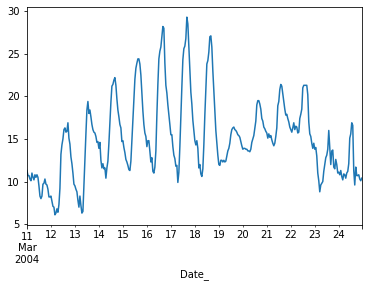

In [17]:
dt_ts.plot(kind = 'line')

In [18]:
dt_ts_reshape = pd.Series(dt_ts.values.reshape(-1,))
dt_ts_reshape

0      11.3
1      10.7
2      10.7
3      10.3
4      10.1
       ... 
331    10.7
332    10.8
333    10.3
334    10.1
335    10.4
Length: 336, dtype: float64

# Model to predict Temperature

In [19]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [20]:
def data_sequences(ts_values):
    X_t, y_t = split_sequence(ts_values, n_steps)
    return X_t, y_t

In [23]:
# train --> 6 days
# val --> 1 day
# forecast --> 1 day

In [115]:
def train_test_sequences(X_t, y_t):
    X_t_train, y_t_train = X_t[:144-n_steps], y_t[:144-n_steps]
    X_t_val, y_t_val = X_t[144-n_steps:], y_t[144-n_steps:]
    return X_t_train, y_t_train, X_t_val, y_t_val

In [64]:
# define model
def TS_model(units_):
    
    model = Sequential()  
    model.add(LSTM(units=units_, input_shape=(n_steps, 1), activation = 'relu'))  
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu', return_sequences = True))  
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu'))  
#     model.add(Dropout(0.2))
      
    model.add(Dense(units = 1))  
    
    model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
    return model

In [92]:
def train_model(model, batch_size_, idx):
    earlyStopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('temp_model_%s.hdf5'%idx, save_best_only=True, 
                           monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, 
                                       verbose=1, min_delta=1e-4, mode='min')
    
    mod_trained = model.fit(X_t_train, y_t_train, epochs = 100, validation_data = (X_t_val, y_t_val), 
              batch_size = batch_size_, verbose = 2,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
             )
    return mod_trained

In [117]:
# params
n_steps = 15
units = 50
batch_size = 16


# train model

start = datetime.datetime.now()

ts_model = TS_model(units)

mape_list = []
mod_list = []
pred_all = []

# X_train_all = []
# X_val_all = []
# y_train_all = []
# y_val_all = []

for day_idx in range(7):
    X_t, y_t = data_sequences(dt_ts_reshape[24*day_idx:24*(day_idx+7)].values)
    X_t_train, y_t_train, X_t_val, y_t_val = train_test_sequences(X_t, y_t)
    
#     X_train_all.append(X_t_train)
#     X_val_all.append(X_t_val)
#     y_train_all.append(y_t_train)
#     y_val_all.append(y_t_val)
    
    
    mod_trained = train_model(ts_model, batch_size, day_idx)
    best_model = load_model('temp_model_%s.hdf5'%day_idx)
    mod_list.append(best_model)
    
    X_t_test, y_t_test = data_sequences(dt_ts_reshape[24*(day_idx+7)-n_steps:24*(day_idx+8)].values)
#     print(24*day_idx, 24*(day_idx+6), 24*(day_idx+7))
#     print(X_t_train.shape, X_t_val.shape, X_t_test.shape)
    pred = best_model.predict(X_t_test)
    mape = mean_absolute_percentage_error(y_t_test, pred)
    
    pred_all.extend(pred)
    mape_list.append(mape)
            
    print('Forecasting for %s done, train and val set used is from %s until %s'%(dt_ts.index[24*(day_idx+7)].date(), dt_ts.index[24*(day_idx)].date(), dt_ts.index[24*(day_idx+6)].date()))
            
            
print("time needed for all process --> ", datetime.datetime.now()-start)

Epoch 1/100
9/9 - 1s - loss: 69.6217 - val_loss: 34.4549 - lr: 0.0010 - 717ms/epoch - 80ms/step
Epoch 2/100
9/9 - 0s - loss: 37.9480 - val_loss: 21.8747 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 3/100
9/9 - 0s - loss: 24.6961 - val_loss: 22.4264 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 4/100
9/9 - 0s - loss: 25.6303 - val_loss: 21.6417 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 5/100
9/9 - 0s - loss: 25.7112 - val_loss: 19.6922 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 6/100
9/9 - 0s - loss: 22.8468 - val_loss: 14.2375 - lr: 0.0010 - 45ms/epoch - 5ms/step
Epoch 7/100
9/9 - 0s - loss: 21.4171 - val_loss: 14.7695 - lr: 0.0010 - 37ms/epoch - 4ms/step
Epoch 8/100
9/9 - 0s - loss: 19.3131 - val_loss: 19.1590 - lr: 0.0010 - 39ms/epoch - 4ms/step
Epoch 9/100
9/9 - 0s - loss: 20.4306 - val_loss: 13.2976 - lr: 0.0010 - 44ms/epoch - 5ms/step
Epoch 10/100
9/9 - 0s - loss: 19.2265 - val_loss: 11.9051 - lr: 0.0010 - 44ms/epoch - 5ms/step
Epoch 11/100
9/9 - 0s - loss: 20.2021 - val_loss: 14.2435

Epoch 88/100
9/9 - 0s - loss: 13.0366 - val_loss: 7.9763 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 89/100
9/9 - 0s - loss: 12.7380 - val_loss: 7.4485 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 90/100
9/9 - 0s - loss: 12.4054 - val_loss: 7.5899 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 91/100
9/9 - 0s - loss: 13.4804 - val_loss: 9.8530 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 92/100
9/9 - 0s - loss: 14.0564 - val_loss: 6.6807 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 93/100
9/9 - 0s - loss: 13.1070 - val_loss: 6.7016 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 94/100
9/9 - 0s - loss: 11.3561 - val_loss: 8.6785 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 95/100
9/9 - 0s - loss: 11.8251 - val_loss: 6.6982 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 96/100
9/9 - 0s - loss: 13.5294 - val_loss: 6.6148 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 97/100
9/9 - 0s - loss: 12.6953 - val_loss: 7.7924 - lr: 0.0010 - 36ms/epoch - 4ms/step
Epoch 98/100
9/9 - 0s - loss: 11.1032 - val_loss: 7.0716 - l

Epoch 75/100
9/9 - 0s - loss: 12.0988 - val_loss: 7.0466 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 76/100
9/9 - 0s - loss: 12.1282 - val_loss: 6.1396 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 77/100
9/9 - 0s - loss: 11.2693 - val_loss: 6.6503 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 78/100
9/9 - 0s - loss: 11.8828 - val_loss: 6.1108 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 79/100
9/9 - 0s - loss: 10.8238 - val_loss: 5.8401 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 80/100
9/9 - 0s - loss: 10.8478 - val_loss: 6.9155 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 81/100
9/9 - 0s - loss: 11.6522 - val_loss: 6.8473 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 82/100
9/9 - 0s - loss: 11.3570 - val_loss: 6.0787 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 83/100
9/9 - 0s - loss: 11.2348 - val_loss: 6.8323 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 84/100
9/9 - 0s - loss: 11.3376 - val_loss: 6.2651 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 85/100
9/9 - 0s - loss: 10.8364 - val_loss: 5.2973 - l

Epoch 59/100
9/9 - 0s - loss: 9.6757 - val_loss: 2.4192 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 60/100
9/9 - 0s - loss: 10.6626 - val_loss: 2.2235 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 61/100
9/9 - 0s - loss: 9.3839 - val_loss: 2.1511 - lr: 1.0000e-04 - 33ms/epoch - 4ms/step
Epoch 62/100
9/9 - 0s - loss: 10.5879 - val_loss: 2.0199 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 63/100
9/9 - 0s - loss: 9.3457 - val_loss: 2.0957 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 64/100
9/9 - 0s - loss: 8.4678 - val_loss: 2.0512 - lr: 1.0000e-04 - 36ms/epoch - 4ms/step
Epoch 65/100
9/9 - 0s - loss: 9.6721 - val_loss: 2.0368 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 66/100
9/9 - 0s - loss: 9.7465 - val_loss: 1.9725 - lr: 1.0000e-04 - 42ms/epoch - 5ms/step
Epoch 67/100
9/9 - 0s - loss: 9.8544 - val_loss: 1.9275 - lr: 1.0000e-04 - 42ms/epoch - 5ms/step
Epoch 68/100
9/9 - 0s - loss: 10.9095 - val_loss: 1.9666 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 69/100
9/9 - 0s - los

Epoch 43/100
9/9 - 0s - loss: 9.0842 - val_loss: 2.5922 - lr: 1.0000e-04 - 36ms/epoch - 4ms/step
Epoch 44/100
9/9 - 0s - loss: 9.6096 - val_loss: 2.8048 - lr: 1.0000e-04 - 36ms/epoch - 4ms/step
Epoch 45/100
9/9 - 0s - loss: 8.8410 - val_loss: 2.5973 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 46/100
9/9 - 0s - loss: 8.7839 - val_loss: 2.4227 - lr: 1.0000e-04 - 36ms/epoch - 4ms/step
Epoch 47/100
9/9 - 0s - loss: 9.0296 - val_loss: 2.6783 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 48/100
9/9 - 0s - loss: 9.9589 - val_loss: 3.0181 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 49/100
9/9 - 0s - loss: 10.7705 - val_loss: 2.8196 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 50/100
9/9 - 0s - loss: 9.3010 - val_loss: 2.8768 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 51/100
9/9 - 0s - loss: 8.9393 - val_loss: 2.9135 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 52/100
9/9 - 0s - loss: 8.9246 - val_loss: 3.0963 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 53/100
9/9 - 0s - loss:

Epoch 26/100
9/9 - 0s - loss: 10.2928 - val_loss: 4.3501 - lr: 1.0000e-05 - 35ms/epoch - 4ms/step
Epoch 27/100
9/9 - 0s - loss: 10.3357 - val_loss: 4.3586 - lr: 1.0000e-05 - 35ms/epoch - 4ms/step
Epoch 28/100
9/9 - 0s - loss: 7.6851 - val_loss: 4.3938 - lr: 1.0000e-05 - 35ms/epoch - 4ms/step
Epoch 29/100
9/9 - 0s - loss: 9.5385 - val_loss: 4.3670 - lr: 1.0000e-05 - 36ms/epoch - 4ms/step
Epoch 30/100
9/9 - 0s - loss: 8.8556 - val_loss: 4.4009 - lr: 1.0000e-05 - 35ms/epoch - 4ms/step
Epoch 31/100
9/9 - 0s - loss: 9.3323 - val_loss: 4.4481 - lr: 1.0000e-05 - 34ms/epoch - 4ms/step
Epoch 32/100
9/9 - 0s - loss: 10.6116 - val_loss: 4.5326 - lr: 1.0000e-05 - 36ms/epoch - 4ms/step
Epoch 33/100
9/9 - 0s - loss: 8.9248 - val_loss: 4.5250 - lr: 1.0000e-05 - 35ms/epoch - 4ms/step
Epoch 34/100
9/9 - 0s - loss: 9.1795 - val_loss: 4.5599 - lr: 1.0000e-05 - 36ms/epoch - 4ms/step
Epoch 35/100
9/9 - 0s - loss: 10.4409 - val_loss: 4.6034 - lr: 1.0000e-05 - 34ms/epoch - 4ms/step
Epoch 36/100
9/9 - 0s - lo

Epoch 9/100
9/9 - 0s - loss: 9.4645 - val_loss: 5.4785 - lr: 1.0000e-06 - 43ms/epoch - 5ms/step
Epoch 10/100
9/9 - 0s - loss: 8.5401 - val_loss: 5.4756 - lr: 1.0000e-06 - 46ms/epoch - 5ms/step
Epoch 11/100
9/9 - 0s - loss: 9.5976 - val_loss: 5.4727 - lr: 1.0000e-06 - 44ms/epoch - 5ms/step
Epoch 12/100
9/9 - 0s - loss: 9.0500 - val_loss: 5.4645 - lr: 1.0000e-06 - 45ms/epoch - 5ms/step
Epoch 13/100
9/9 - 0s - loss: 9.4259 - val_loss: 5.4575 - lr: 1.0000e-06 - 50ms/epoch - 6ms/step
Epoch 14/100
9/9 - 0s - loss: 8.9881 - val_loss: 5.4512 - lr: 1.0000e-06 - 46ms/epoch - 5ms/step
Epoch 15/100
9/9 - 0s - loss: 9.0022 - val_loss: 5.4554 - lr: 1.0000e-06 - 36ms/epoch - 4ms/step
Epoch 16/100
9/9 - 0s - loss: 9.5631 - val_loss: 5.4606 - lr: 1.0000e-06 - 33ms/epoch - 4ms/step
Epoch 17/100
9/9 - 0s - loss: 8.9066 - val_loss: 5.4582 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 18/100
9/9 - 0s - loss: 9.4866 - val_loss: 5.4585 - lr: 1.0000e-06 - 36ms/epoch - 4ms/step
Epoch 19/100
9/9 - 0s - loss: 9

Epoch 94/100
9/9 - 0s - loss: 9.4450 - val_loss: 5.3887 - lr: 1.0000e-06 - 34ms/epoch - 4ms/step
Epoch 95/100
9/9 - 0s - loss: 9.2369 - val_loss: 5.3887 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 96/100
9/9 - 0s - loss: 9.6223 - val_loss: 5.3907 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 97/100
9/9 - 0s - loss: 10.0405 - val_loss: 5.3853 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 98/100
9/9 - 0s - loss: 9.4582 - val_loss: 5.3789 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 99/100
9/9 - 0s - loss: 8.0463 - val_loss: 5.3730 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 100/100
9/9 - 0s - loss: 9.7700 - val_loss: 5.3744 - lr: 1.0000e-06 - 34ms/epoch - 4ms/step
Forecasting for 2004-03-23 done, train and val set used is from 2004-03-16 until 2004-03-22
Epoch 1/100
9/9 - 0s - loss: 8.4086 - val_loss: 9.7755 - lr: 1.0000e-06 - 58ms/epoch - 6ms/step
Epoch 2/100
9/9 - 0s - loss: 10.4952 - val_loss: 9.7788 - lr: 1.0000e-06 - 35ms/epoch - 4ms/step
Epoch 3/100
9/9 - 0s - loss: 9.294

Epoch 77/100
9/9 - 0s - loss: 9.3176 - val_loss: 9.8090 - lr: 1.0000e-07 - 37ms/epoch - 4ms/step
Epoch 78/100
9/9 - 0s - loss: 9.4966 - val_loss: 9.8097 - lr: 1.0000e-07 - 36ms/epoch - 4ms/step
Epoch 79/100
9/9 - 0s - loss: 9.6056 - val_loss: 9.8105 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 80/100
9/9 - 0s - loss: 9.0332 - val_loss: 9.8110 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 81/100
9/9 - 0s - loss: 9.1295 - val_loss: 9.8115 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 82/100
9/9 - 0s - loss: 9.0099 - val_loss: 9.8116 - lr: 1.0000e-07 - 34ms/epoch - 4ms/step
Epoch 83/100
9/9 - 0s - loss: 8.9715 - val_loss: 9.8119 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 84/100
9/9 - 0s - loss: 8.6161 - val_loss: 9.8116 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 85/100
9/9 - 0s - loss: 8.5446 - val_loss: 9.8116 - lr: 1.0000e-07 - 36ms/epoch - 4ms/step
Epoch 86/100
9/9 - 0s - loss: 8.3501 - val_loss: 9.8123 - lr: 1.0000e-07 - 35ms/epoch - 4ms/step
Epoch 87/100
9/9 - 0s - loss: 

In [118]:
mape_list

[0.0647319904458733,
 0.03410404366432868,
 0.022607545274580896,
 0.03303950888668771,
 0.052091179495949456,
 0.09829777892268378,
 0.11244584694336264]

In [131]:
date_list = [str(dt_ts.index[24*(day_idx+7)].date()) for day_idx in range(7)]
date_list

['2004-03-18',
 '2004-03-19',
 '2004-03-20',
 '2004-03-21',
 '2004-03-22',
 '2004-03-23',
 '2004-03-24']

In [132]:
mape_all = statistics.mean(mape_list)
mape_list.append(mape_all)

date_list.append('Average')

In [133]:
error_df = pd.DataFrame(list(zip(date_list, mape_list)),
                       columns = ['Date', 'MAPE'])

error_df

,Date,MAPE
0,2004-03-18,0.064732
1,2004-03-19,0.034104
2,2004-03-20,0.022608
3,2004-03-21,0.033040
4,2004-03-22,0.052091
5,2004-03-23,0.098298
6,2004-03-24,0.112446
7,Average,0.059617


In [43]:
168/24

7.0

In [45]:
len(dt_ts[169:])

167

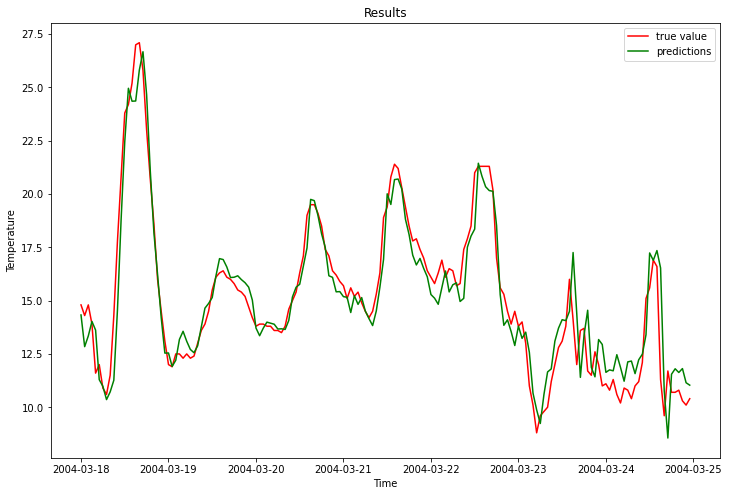

In [120]:
index = dt_ts.index

plt.figure(figsize=(12,8))
plt.plot(index[168:], dt_ts[168:].values, color = 'r', label = 'true value')
plt.plot(index[168:], pred_all, color = 'g', label = 'predictions')
plt.title('Results')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [164]:
mod_list[0].summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 50)                10400     
                                                                 
 dropout_23 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [125]:
mean_absolute_percentage_error(dt_ts[168+24:168+48].values, pred_all[24:48])

0.03410404366432868

In [158]:
date_pred = [dt_ts.index[i] for i in range(168,336)]

In [159]:
pred_all_list = [pred_all[i][0] for i in range(len(pred_all))]

In [162]:
pred_dt = pd.DataFrame(list(zip(date_pred, pred_all_list)),
                      columns = ['Date', 'temp_predict'])
pred_dt.to_csv('temp_pred.csv')

In [163]:
pred_dt.head()

,Date,temp_predict
0,2004-03-18 00:00:00,14.327377
1,2004-03-18 01:00:00,12.841265
2,2004-03-18 02:00:00,13.344208
3,2004-03-18 03:00:00,14.025393
4,2004-03-18 04:00:00,13.617889
